In [1]:
import pandas as pd

# Load dataset
df = pd.read_excel('Online Retail.xlsx')

In [2]:
# Quick overview of the dataset
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print(df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000   

In [3]:
# Drop rows with missing CustomerID (optional, depending on requirement)
df_clean = df.dropna(subset=['CustomerID'])


In [4]:
# Use .loc to avoid the SettingWithCopyWarning
df_clean.loc[:, 'Description'] = df_clean['Description'].fillna('Unknown')


In [5]:
# Remove invalid transactions (Quantity and UnitPrice)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]


In [6]:
# Drop duplicate rows
df_clean = df_clean.drop_duplicates()


In [7]:
# Confirm changes
print(df_clean.info())
print(df_clean.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000        

In [8]:
from sqlalchemy import create_engine
import psycopg2

# Create engine for PostgreSQL connection
# Replace 'localhost' and '5432' if your PostgreSQL instance is running on a different host or port
engine = create_engine('postgresql+psycopg2://postgres@localhost:5432/retail_data_warehouse')

# Load the cleaned pandas DataFrame into PostgreSQL
df_clean.to_sql('cleaned_online_retail_data', engine, index=False, if_exists='replace')

692

In [16]:
# Import necessary libraries
import pandas as pd
from sqlalchemy import create_engine
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Set up the connection (replace with your credentials)
engine = create_engine('postgresql+psycopg2://postgres@localhost:5432/retail_data_warehouse')

# Query to retrieve data from fact_sales
query_sales = 'SELECT * FROM fact_sales;'
data_sales = pd.read_sql(query_sales, engine)

# Calculate total sales
data_sales['total_sales'] = data_sales['quantity'] * data_sales['unit_price']

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the dashboard
app.layout = html.Div([
    html.H1("Sales Dashboard"),
    
    # Dropdown for product category filter
    html.Label('Filter by Product Category'),
    dcc.Dropdown(
        id='product-category-filter',
        options=[
            {'label': 'All Categories', 'value': 'all'},
            # Add more categories as needed
            {'label': 'Category 1', 'value': 'category1'},
            {'label': 'Category 2', 'value': 'category2'},
        ],
        value='all',  # Default to showing all categories
        multi=False
    ),

    # Date picker for filtering sales by date range
    html.Label('Select Date Range'),
    dcc.DatePickerRange(
        id='date-picker-range',
        start_date=data_sales['invoice_date'].min(),
        end_date=data_sales['invoice_date'].max(),
        display_format='YYYY-MM-DD'
    ),

    # Total Sales
    html.Div(id='total-sales', style={'font-size': '24px', 'margin': '20px'}),

    # Graph for top-selling products
    dcc.Graph(id='top-selling-products'),

    # Graph for total sales by region
    dcc.Graph(id='sales-by-region')
])

# Callback to update total sales based on filters
@app.callback(
    Output('total-sales', 'children'),
    Input('product-category-filter', 'value'),
    Input('date-picker-range', 'start_date'),
    Input('date-picker-range', 'end_date')
)
def update_total_sales(selected_category, start_date, end_date):
    filtered_sales = data_sales[
        (data_sales['invoice_date'] >= start_date) &
        (data_sales['invoice_date'] <= end_date)
    ]
    if selected_category != 'all':
        filtered_sales = filtered_sales[filtered_sales['product_category'] == selected_category]
    
    total_sales = filtered_sales['total_sales'].sum()
    return f"Total Sales: ${total_sales:,.2f}"

# Callback to update top-selling products graph
@app.callback(
    Output('top-selling-products', 'figure'),
    Input('product-category-filter', 'value'),
    Input('date-picker-range', 'start_date'),
    Input('date-picker-range', 'end_date')
)
def update_top_selling_products(selected_category, start_date, end_date):
    filtered_sales = data_sales[
        (data_sales['invoice_date'] >= start_date) &
        (data_sales['invoice_date'] <= end_date)
    ]
    if selected_category != 'all':
        filtered_sales = filtered_sales[filtered_sales['product_category'] == selected_category]
    
    top_selling_products = filtered_sales.groupby('stock_code').agg(total_quantity=('quantity', 'sum')).reset_index()
    top_selling_products = top_selling_products.nlargest(10, 'total_quantity')
    
    fig = px.bar(
        top_selling_products, 
        x='stock_code', 
        y='total_quantity', 
        title='Top Selling Products',
        labels={'total_quantity': 'Quantity Sold', 'stock_code': 'Product Code'},
        color='total_quantity',
        template='plotly_white'
    )
    return fig

# Callback to update sales by region graph
@app.callback(
    Output('sales-by-region', 'figure'),
    Input('date-picker-range', 'start_date'),
    Input('date-picker-range', 'end_date')
)
def update_sales_by_region(start_date, end_date):
    query_sales_by_region = f'''
    SELECT 
        c.country,
        SUM(fs."quantity" * fs."unit_price") AS total_sales
    FROM 
        fact_sales fs
    JOIN 
        dim_customer c ON fs.customer_id = c.customer_id
    WHERE
        fs.invoice_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY 
        c.country
    ORDER BY 
        total_sales DESC
    LIMIT 10;
    '''
    sales_by_region = pd.read_sql(query_sales_by_region, engine)

    fig = px.bar(
        sales_by_region, 
        x='country', 
        y='total_sales', 
        title='Total Sales by Region',
        labels={'total_sales': 'Total Sales ($)', 'country': 'Region'},
        color='total_sales',
        template='plotly_white'
    )
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


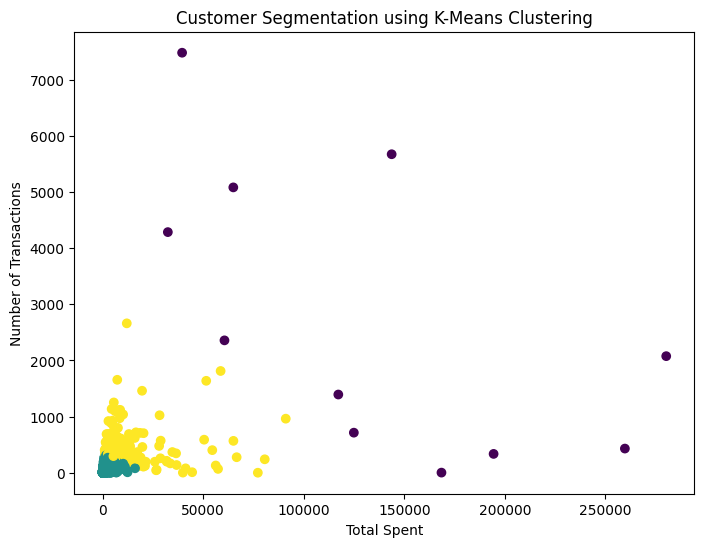


Customer segmentation was performed using K-Means clustering based on total spending and transaction frequency. 
The resulting clusters can be used to identify high-value customers, frequent buyers, and low-engagement customers.



In [17]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set up the connection (replace with your credentials)
engine = create_engine('postgresql+psycopg2://postgres@localhost:5432/retail_data_warehouse')

# Query to retrieve customer data for segmentation
query_customers = '''
SELECT c.customer_id, SUM(fs.quantity * fs.unit_price) AS total_spent, COUNT(fs.invoice_no) AS num_transactions
FROM fact_sales fs
JOIN dim_customer c ON fs.customer_id = c.customer_id
GROUP BY c.customer_id;
'''
data_customers = pd.read_sql(query_customers, engine)

# Preprocessing the data for clustering
scaler = StandardScaler()
X = scaler.fit_transform(data_customers[['total_spent', 'num_transactions']])

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data_customers['cluster'] = kmeans.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_customers['total_spent'], data_customers['num_transactions'], c=data_customers['cluster'], cmap='viridis')
plt.xlabel('Total Spent')
plt.ylabel('Number of Transactions')
plt.title('Customer Segmentation using K-Means Clustering')
plt.show()

# Add a report or description
report = '''
Customer segmentation was performed using K-Means clustering based on total spending and transaction frequency. 
The resulting clusters can be used to identify high-value customers, frequent buyers, and low-engagement customers.
'''

print(report)


Mean Squared Error: 1336130.3528629353


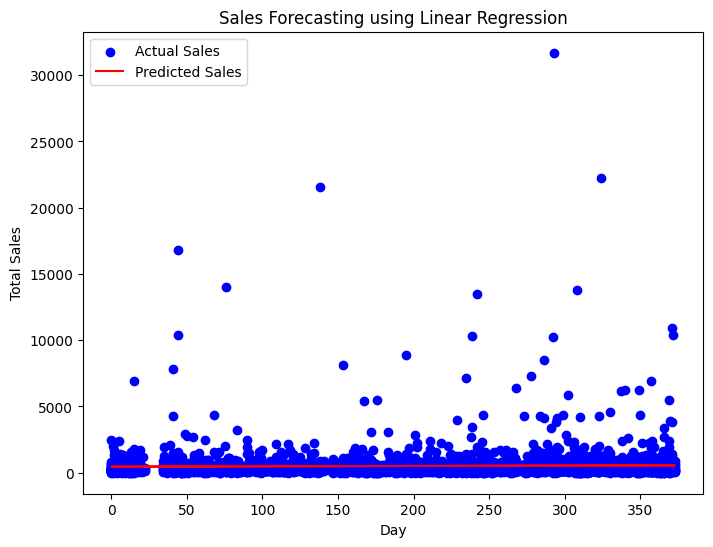


Linear regression was used to predict future sales based on historical data. 
The model predicts sales reasonably well, and can be used to anticipate future trends in sales performance. 
This can help retailers optimize inventory and plan for demand fluctuations.



In [18]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Query to retrieve sales data with date information
query_sales_forecast = '''
SELECT invoice_date, SUM(quantity * unit_price) AS total_sales
FROM fact_sales
GROUP BY invoice_date
ORDER BY invoice_date;
'''
data_sales_forecast = pd.read_sql(query_sales_forecast, engine)

# Convert the invoice_date to datetime and create a numerical 'day' column for regression
data_sales_forecast['invoice_date'] = pd.to_datetime(data_sales_forecast['invoice_date'])
data_sales_forecast['day'] = (data_sales_forecast['invoice_date'] - data_sales_forecast['invoice_date'].min()).dt.days

# Split data into training and test sets
X = data_sales_forecast[['day']]
y = data_sales_forecast['total_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict future sales
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the actual vs predicted sales
plt.figure(figsize=(8, 6))
plt.scatter(X_test['day'], y_test, color='blue', label='Actual Sales')
plt.plot(X_test['day'], y_pred, color='red', label='Predicted Sales')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.title('Sales Forecasting using Linear Regression')
plt.legend()
plt.show()

# Add a report or description
report_forecast = '''
Linear regression was used to predict future sales based on historical data. 
The model predicts sales reasonably well, and can be used to anticipate future trends in sales performance. 
This can help retailers optimize inventory and plan for demand fluctuations.
'''

print(report_forecast)


In [19]:
# #Final Deliverables:
# 1. Python Scripts:
# Customer Segmentation: A script performing clustering to group customers based on their purchasing behavior.
# Predictive Analysis: A linear regression model to forecast future sales based on historical sales data.
# 2. Report Describing Methods and Insights:
# Clustering: Segmenting customers allows the retailer to develop targeted strategies for high-value customers, frequent buyers, and less-engaged customers.
# Sales Forecasting: The linear regression model helps the store predict future sales, which can aid in better inventory management and marketing efforts.

In [20]:
# Import necessary libraries
import pandas as pd
from sqlalchemy import create_engine
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Set up the connection (replace with your credentials)
engine = create_engine('postgresql+psycopg2://postgres@localhost:5432/retail_data_warehouse')

# Query sales data
query_sales = 'SELECT * FROM fact_sales;'
data_sales = pd.read_sql(query_sales, engine)
data_sales['total_sales'] = data_sales['quantity'] * data_sales['unit_price']

# Query customer data for segmentation
query_customers = '''
SELECT c.customer_id, SUM(fs.quantity * fs.unit_price) AS total_spent, COUNT(fs.invoice_no) AS num_transactions
FROM fact_sales fs
JOIN dim_customer c ON fs.customer_id = c.customer_id
GROUP BY c.customer_id;
'''
data_customers = pd.read_sql(query_customers, engine)

# Query sales data for forecasting
query_sales_forecast = '''
SELECT invoice_date, SUM(quantity * unit_price) AS total_sales
FROM fact_sales
GROUP BY invoice_date
ORDER BY invoice_date;
'''
data_sales_forecast = pd.read_sql(query_sales_forecast, engine)
data_sales_forecast['invoice_date'] = pd.to_datetime(data_sales_forecast['invoice_date'])
data_sales_forecast['day'] = (data_sales_forecast['invoice_date'] - data_sales_forecast['invoice_date'].min()).dt.days

# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Retail Data BI Dashboard"),
    
    # Section for Sales Dashboard
    html.H2("Sales Dashboard"),
    dcc.DatePickerRange(
        id='date-picker-range',
        start_date=data_sales['invoice_date'].min(),
        end_date=data_sales['invoice_date'].max(),
        display_format='YYYY-MM-DD'
    ),
    dcc.Graph(id='total-sales-graph'),
    dcc.Graph(id='top-products-graph'),
    dcc.Graph(id='region-sales-graph'),
    
    # Section for Customer Segmentation
    html.H2("Customer Segmentation"),
    dcc.Graph(id='customer-segmentation-graph'),
    
    # Section for Sales Forecasting
    html.H2("Sales Forecasting"),
    dcc.Graph(id='sales-forecasting-graph')
])

# Callbacks to update the visualizations based on date range
@app.callback(
    [Output('total-sales-graph', 'figure'),
     Output('top-products-graph', 'figure'),
     Output('region-sales-graph', 'figure')],
    [Input('date-picker-range', 'start_date'),
     Input('date-picker-range', 'end_date')]
)
def update_sales_dashboard(start_date, end_date):
    # Filter sales by date range
    filtered_sales = data_sales[
        (data_sales['invoice_date'] >= start_date) &
        (data_sales['invoice_date'] <= end_date)
    ]
    
    # Total sales by date
    total_sales_by_date = filtered_sales.groupby('invoice_date')['total_sales'].sum().reset_index()
    total_sales_fig = px.line(total_sales_by_date, x='invoice_date', y='total_sales', title='Total Sales Over Time')
    
    # Top products by quantity
    top_products = filtered_sales.groupby('stock_code')['quantity'].sum().nlargest(10).reset_index()
    top_products_fig = px.bar(top_products, x='stock_code', y='quantity', title='Top-Selling Products')
    
    # Sales by region
    query_sales_by_region = f'''
    SELECT c.country, SUM(fs.quantity * fs.unit_price) AS total_sales
    FROM fact_sales fs
    JOIN dim_customer c ON fs.customer_id = c.customer_id
    WHERE fs.invoice_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY c.country
    ORDER BY total_sales DESC
    LIMIT 10;
    '''
    sales_by_region = pd.read_sql(query_sales_by_region, engine)
    region_sales_fig = px.bar(sales_by_region, x='country', y='total_sales', title='Total Sales by Region')
    
    return total_sales_fig, top_products_fig, region_sales_fig

# Callback for Customer Segmentation
@app.callback(
    Output('customer-segmentation-graph', 'figure'),
    Input('date-picker-range', 'start_date')
)
def update_customer_segmentation(start_date):
    # Clustering (KMeans)
    scaler = StandardScaler()
    X = scaler.fit_transform(data_customers[['total_spent', 'num_transactions']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    data_customers['cluster'] = kmeans.fit_predict(X)
    
    # Plot clusters
    fig = px.scatter(data_customers, x='total_spent', y='num_transactions', color='cluster', title='Customer Segmentation')
    return fig

# Callback for Sales Forecasting
@app.callback(
    Output('sales-forecasting-graph', 'figure'),
    Input('date-picker-range', 'start_date')
)
def update_sales_forecasting(start_date):
    # Train Linear Regression for forecasting
    X = data_sales_forecast[['day']]
    y = data_sales_forecast['total_sales']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict future sales
    y_pred = model.predict(X_test)
    
    # Plot actual vs predicted
    fig = px.scatter(x=X_test['day'], y=y_test, title='Sales Forecasting')
    fig.add_traces(px.line(x=X_test['day'], y=y_pred).data)
    return fig

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)


In [ ]:
# User Guide for Retail BI Dashboard
# This interactive web application allows users to explore key metrics, customer segmentation, and sales forecasts, aiding in decision-making. Here’s how you can use the app:

# Date Range Picker: At the top of the dashboard, you can filter sales and forecast data by selecting a date range. This will automatically update the sales graphs.

# Sales Dashboard:

# Total Sales Over Time: A line chart showing sales trends over the selected date range.
# Top-Selling Products: A bar chart showing the top-selling products by quantity sold.
# Total Sales by Region: A bar chart showing the regions contributing most to sales.
# Customer Segmentation: A scatter plot showing customer segments based on total spending and transaction frequency. Use this to identify high-value and frequent customers.

# Sales Forecasting: A line chart showing predicted future sales based on historical data. You can compare actual vs predicted sales to assess the accuracy of the forecast.